In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import pandas as pd

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/texturemodel/code/'
sys.path.insert(0,codepath)

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params, pycortex_plot_utils
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, stats_utils, nsd_utils
from feature_extraction import texture_statistics_pyramid


/home/mmhender/imstat_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load model fits

In [2]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type = 'texture_pyramid_ridge_4ori_4sf_pcaHL_allsubsets_use_texture_pRFs'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, \
                                  n_from_end=0, verbose=False) \
       for ss in subjects]

# shuffled model fits, to compute significance of model fit each ROI.
fitting_type_shuffle = 'texture_pyramid_ridge_4ori_4sf_pcaHL_use_texture_pRFs_permutation_test'
out_shuff = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type_shuffle, \
                                  n_from_end=0, verbose=False) \
                                    for ss in subjects]

# bootstrap results, for significance of unique variance explained each feature set
fitting_type_boot = 'texture_pyramid_ridge_4ori_4sf_pcaHL_allsubsets_use_texture_pRFs_bootstrap_test_val'
out_boot = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type_boot, \
                                  n_from_end=0, verbose=False) \
                                    for ss in subjects]

#### Make ROI definitions

In [3]:
roi_def = roi_utils.multi_subject_roi_def(subjects, areas_include = ['V1','V2','V3','hV4', \
                                                      'OPA','PPA','RSC',\
                                                      'FFA','EBA'], use_kastner_areas=False, \
                                         remove_ret_overlap=True, remove_categ_overlap=True)
roi_names = roi_def.roi_names;
n_rois = len(roi_names)

#### Process results of permutation test, compute p-values

In [4]:
pvals_singlevoxels_modelsig = [[] for si in range(n_subjects)]

for si in range(n_subjects):

    # stats for single voxels
    r2_real = out[si]['val_r2']
    r2_shuff = out_shuff[si]['val_r2']

    # for how many of the shuffle iterations did shuffle-R2 exceed real-R2?
    p = np.mean(r2_real[:,0,None]<=r2_shuff[:,0,:], axis=1)
    _,pvals_fdr = stats_utils.fdr_keepshape(p, alpha=0.01, \
                                                   method='poscorr')
    
    pvals_singlevoxels_modelsig[si] = pvals_fdr
    

#### Prepare to analyze variance partition results, set params

In [5]:
ff_inds = np.arange(1,11)
n_submodels = len(ff_inds)

ve_names = ['Unique: ' + out[0]['partial_version_names'][ff].split('leave_out_')[1] \
                             for ff in ff_inds]

ll_colors = cm.Blues(np.linspace(0,1,7))[3:9,:]
hl_colors = cm.Reds(np.linspace(0,1,9))[3:11,:]
colors = np.concatenate([ll_colors, hl_colors], axis=0)

feature_types_simple = [out[0]['partial_version_names'][ff].split('leave_out_')[1] \
                             for ff in ff_inds]

#### Process results of bootstrap test for unique variance, compute p-values

In [6]:
n_feature_types = n_submodels

pvals_singlevoxels_uniquesig = [[] for si in range(n_subjects)]

pvals_rois_uniquesig = np.zeros((n_subjects, n_rois, n_feature_types))

propvox_uniquesig = np.zeros((n_subjects, n_rois+1, n_feature_types))

n_iter = out_boot[si]['val_r2'].shape[2]
unique_boot_mean =  np.zeros((n_subjects, n_rois, n_feature_types, n_iter))

for si in range(n_subjects):
    
    # identify all the voxels where the model fit was above chance, and noise ceiling was good
    model_sig = pvals_singlevoxels_modelsig[si]<0.01
    abv_thresh = summary_plots.get_noise_ceiling(out[si])>0.01

    r2_boot = out_boot[si]['val_r2']
    # R2 full - R2 partial = unique var
    unique_boot = r2_boot[:,0:1,:] - r2_boot[:,1:,:]
    
    pvals_fdr_all  = np.zeros((r2_boot.shape[0],n_feature_types))
    
    for ff in range(n_feature_types):

        # for how many of the bootstrap iterations was unique <= 0?
        p = np.mean(unique_boot[:,ff,:]<=0, axis=1)
        # fdr correct across voxels
        _,pvals_fdr = stats_utils.fdr_keepshape(p, alpha=0.01, \
                                                       method='poscorr')
        pvals_fdr_all[:,ff] = pvals_fdr
        
        # how many voxels were significant (all areas)
        propvox_uniquesig[si,n_rois,ff] = np.mean(pvals_fdr[abv_thresh & model_sig]<0.01)
        
        for rr in range(n_rois):

            inds = roi_def.ss_roi_defs[si].get_indices(rr) & abv_thresh & model_sig
         
            # how many voxels were significant (this ROI)
            propvox_uniquesig[si,rr,ff] = np.mean(pvals_fdr[inds]<0.01)
            
            # average the individual bootstrapped values across voxels, in this ROI
            roimean = np.mean(unique_boot[inds,ff,:], axis=0)
            
            unique_boot_mean[si,rr,ff,:] = roimean
                                    
            # p-value for whether ROI-averaged unique var is abv chance
            pvals_rois_uniquesig[si,rr,ff] = np.mean(roimean<=0)
            
           
    pvals_singlevoxels_uniquesig[si] = pvals_fdr_all

# correct the ROI-averaged p-values for multiple comparisons
issig_rois_uniquesig_hb, thrs = stats_utils.holm_bonferroni(pvals_rois_uniquesig, q=0.01)


#### get subject-averaged stats
average results of each bootstrapping iteration, over all subjects

In [7]:
unique_boot_avgsubs = np.mean(unique_boot_mean, axis=0)
lowci, median, highci = np.percentile(unique_boot_avgsubs, [0.5, 50, 99.5], axis=2)

pvals_rois_uniquesig_avgsubj = np.mean(unique_boot_avgsubs<=0, axis=2)
roi_sig_mask, thrs = stats_utils.holm_bonferroni(pvals_rois_uniquesig_avgsubj, q=0.01)


In [9]:
pvals_rois_uniquesig_avgsubj[8,:]

array([0.   , 0.003, 0.043, 0.   , 0.001, 0.   , 0.   , 0.   , 0.   ,
       0.336])

In [10]:
roi_sig_mask[8,:]

array([ True, False, False,  True, False,  True,  True,  True,  True,
       False])

#### Make a table for how many subjects were individually significant

In [8]:
tables = [[] for ff in range(n_feature_types)]
n_subs = np.sum(issig_rois_uniquesig_hb, axis=0)
df = pd.DataFrame(n_subs.T, columns=roi_names, index=feature_types_simple)
fn2save = os.path.join(default_paths.fig_path, 'nsubj_sig_allsubsets.csv')
print(fn2save)
df.to_csv(fn2save)
df

/user_data/mmhender/texturemodel/figures/nsubj_sig_allsubsets.csv


,V1,V2,V3,hV4,OPA,PPA,RSC,FFA,EBA
pixel,8,8,7,4,2,1,0,0,2
energy-mean,8,8,8,8,3,7,2,4,1
linear-mean,0,0,0,0,0,0,0,0,0
marginal,3,5,3,3,2,2,0,0,0
energy-auto,1,1,0,0,0,0,0,0,0
linear-auto,1,0,1,0,6,5,2,4,4
energy-cross-orient,0,0,0,0,0,0,0,2,2
linear-cross-orient,8,8,7,6,4,3,0,2,1
energy-cross-scale,2,0,1,3,2,1,0,0,4
linear-cross-scale,4,2,2,1,0,1,0,0,0


#### Plotting bootstrapped confidence intervals 

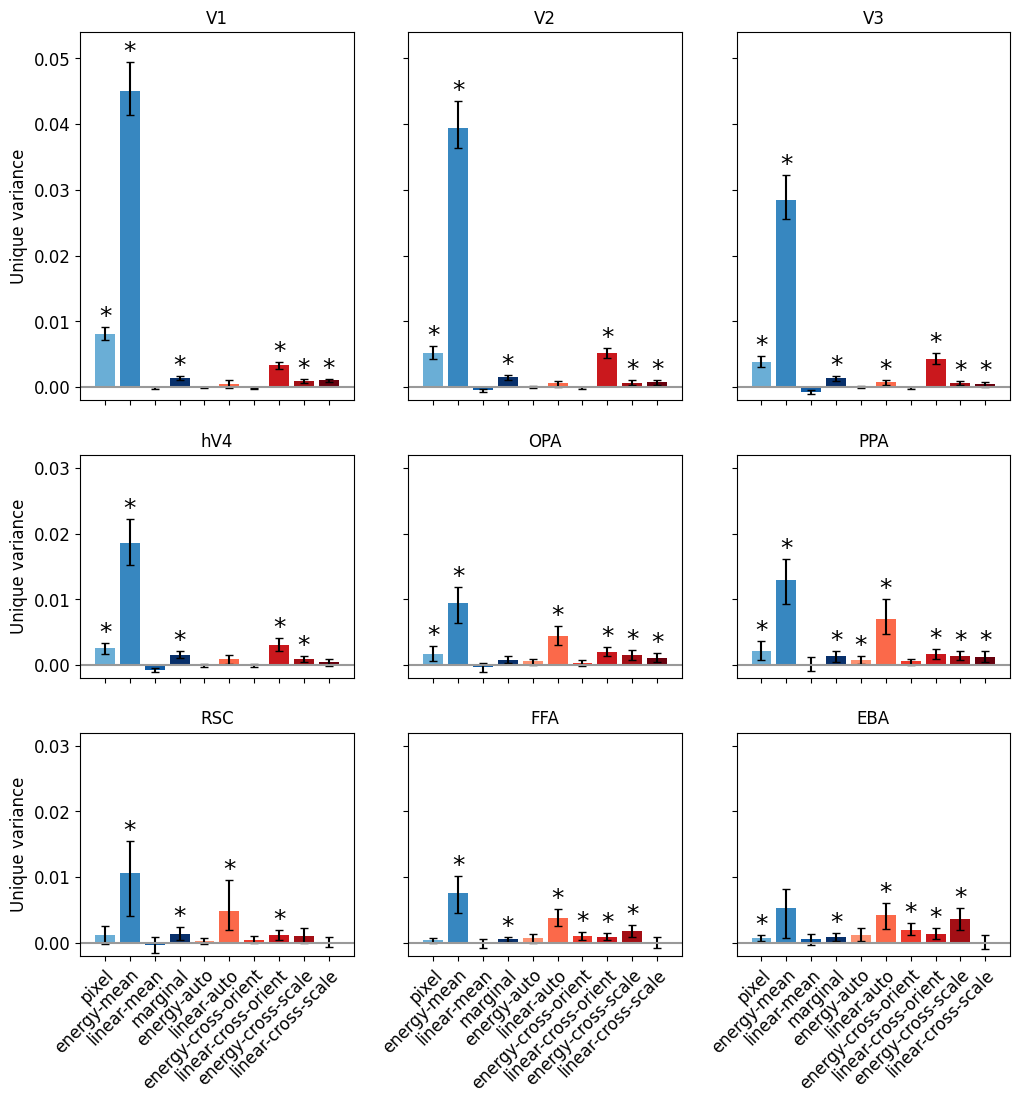

In [9]:
        
import matplotlib.gridspec as gridspec

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 12)
fig = plt.figure(figsize=(12,12))

plot_order = np.arange(10)

ymax_big = 0.054;
ymax_small = 0.032;

ymin_big = -0.002;
ymin_small = -0.002;
ratio = (ymax_big-ymin_big)/(ymax_small-ymin_small);

small = 1/(1+1+ratio*1)
big = small*ratio

outer = gridspec.GridSpec(3, 3, wspace=0.2, hspace=0.2)
outer.set_height_ratios([big, small, small])

for rr in range(n_rois):
    
    ax = plt.Subplot(fig, outer[rr])
        
    for ff in range(n_feature_types):
        ax.bar(ff, median[rr,ff],color=colors[ff,:])
        x = np.array([ff]); y = np.array([median[rr,ff]]); 
        errbars = np.array([[median[rr,ff]-lowci[rr,ff],highci[rr,ff]-median[rr,ff]]]).T

        ax.errorbar(x,y,errbars,\
                 linestyle='none',color='k', capsize=3)
    
    if rr<3:
        ylims = [ymin_big, ymax_big]
    else:
        ylims = [ymin_small, ymax_small]
        
    ax.set_ylim(ylims)

    if rr>5:
        ax.set_xticks(
            np.arange(n_submodels),)
        ax.set_xticklabels(
            np.array(feature_types_simple)[plot_order], 
            # np.array(ve_names)[inds],
            rotation=45,
            ha="right",
            rotation_mode="anchor",
        );
    else:
        ax.set_xticks(np.arange(n_submodels))
        ax.set_xticklabels([])
    # ax.set_yticks(np.arange(ylims[0], ylims[1]+0.0001, 0.01))
    if np.mod(rr,3)==0:
        ax.set_ylabel('Unique variance')
    else:
        ax.set_yticklabels([])
    ax.set_xlim([-1,n_submodels])
    
    ax.axhline(0,color=[0.6, 0.6, 0.6])
    
    for ff in range(n_feature_types):
        if roi_sig_mask[rr,ff]:
            
            xx=ff;
            
            text_lab_ht = highci[rr,ff]+0.0005
            ax.annotate('*', xy=(xx, text_lab_ht),
                        zorder=20, color="k", ha="center", fontsize=18,)
            
    
    ax.set_title(roi_names[rr])
    fig.add_subplot(ax)

        
fn2save = os.path.join(default_paths.fig_path, 'texture_all_subsets_CIs.pdf')
plt.savefig(fn2save)

#### Compute the proportion of total model variance in each ROI for each feature type

In [13]:
n_submodels = len(feature_types_simple)
vals = np.zeros((n_subjects, n_rois, n_submodels))

for si, ss in enumerate(subjects):
    
    val_r2 = out[si]['val_r2']    
    
    var_expl = val_r2[:,0:1] - val_r2[:,ff_inds] 
    
    model_sig = pvals_singlevoxels_modelsig[si]<0.01
    abv_thresh = summary_plots.get_noise_ceiling(out[si])>0.01
    inds2use = model_sig & abv_thresh
   
    for ri in range(n_rois):
        
        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use 
        vals[si,ri,:] = np.mean(var_expl[inds_this_roi,:], axis=0)

# mean over subjects
mean_vals = np.mean(vals, axis=0)
# converting to a proportion of total
mean_vals = mean_vals/np.sum(mean_vals, axis=1, keepdims=True)

np.sum(mean_vals,axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Visualize as stacked bar chart

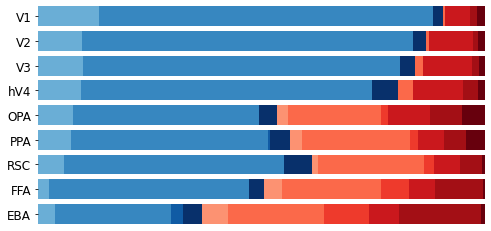

In [14]:
plt.figure(figsize=(8,4))
left = np.zeros((n_rois,))
for ff in np.arange(n_feature_types):
    plt.barh(np.arange(n_rois), mean_vals[:,ff], left=left, color=colors[ff,:],height=0.8)
    left += mean_vals[:,ff];
    # print(bottom)
plt.yticks(np.arange(n_rois), roi_names);
plt.ylim([-0.4, n_rois-0.6])
plt.xlim([0,1])
plt.gca().invert_yaxis()
# plt.axis('off')
plt.xticks([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# plt.legend(feature_types_simple)
fn2save = os.path.join(default_paths.fig_path, 'texture_uniqvar_stackedbar.pdf')
plt.savefig(fn2save)

#### Use PyCortex to make surface plots 

In [11]:

ff2plot = np.arange(10)
volumes = {}

for si, ss in enumerate(subjects):

    names = []
    maps = []
    cmaps = []
    mins = []
    maxes = []

    val_r2 = out[si]['val_r2']        
    var_expl = val_r2[:,0:1] - val_r2[:,ff_inds] 
    
    # names += ['S%d: full model R2'%(ss)]
    # maps += [np.sign(val_r2[:,0]) * np.sqrt(np.abs(val_r2[:,0]))]
    # cmaps += ['Blues']
    # mins += [0]
    # maxes += [0.40]
        
    names += ['S%d: %s (sqrt uniq var)'%(ss, feature_types_simple[ff]) for ff in ff2plot]
    maps += [np.sign(var_expl[:,ff]) * np.sqrt(np.abs(var_expl[:,ff])) for ff in ff2plot]
    
    cmaps += ['Blues' for ff in range(4)]    
    cmaps += ['Reds' for ff in range(6)]
    
    mins += [0 for ff in ff2plot]
    maxes += [0.40 for ff in ff2plot]

    model_sig = pvals_singlevoxels_modelsig[si]<0.01
    abv_thresh = summary_plots.get_noise_ceiling(out[si])>0.01
    
    vox2plot = model_sig & abv_thresh

    voxel_mask = out[si]['voxel_mask']
    nii_shape = out[si]['brain_nii_shape']
    mask_3d = np.reshape(voxel_mask, nii_shape, order='C')

    vol_ss = pycortex_plot_utils.maps_to_volumes(ss, maps, names, \
                         cmaps=cmaps, mins=mins, maxes=maxes, \
                         voxel_mask=voxel_mask, nii_shape=nii_shape, mask_3d=mask_3d, \
                         vox2plot=vox2plot)

    volumes.update(vol_ss)


#### Make the static webviewer html

In [13]:
import cortex
save_html_name = os.path.join(default_paths.fig_path, 'Variance_partition_allsubsets.html')
title = 'Variance partition, all feature subsets'
viewer = cortex.webgl.make_static(outpath= save_html_name, \
                            data = volumes, 
                            recache = False,
                            title = title)


Stopping server


In [12]:
viewer = pycortex_plot_utils.plot_with_overlays(volumes, title='Texture model summary', \
                                                port = 64447, \
                                                labels_on=False, recache=False, \
                                                overlay_type = 'overlays')

using overlays from /user_data/mmhender/pycortex_db/subj01/overlays.svg
navigate browser to: 127.0.0.1:64447
Started server on port 64447


#### Set view and save images of flatmaps

In [50]:
# load pre-made view params from a json file
# (json files are in your pycortex database folder, under subj01/views/)
viewer.get_view('subj01','flat')
viewname='flat'
# to make the view:
# viewer.save_view('subj01','flat1',True)

In [18]:
ss=1;

ff=9;

fn2save = os.path.join(default_paths.fig_path, \
                       'S%02d_texture_unique_%s_%s_raw.png'%(ss, feature_types_simple[ff], viewname))
print('saving to %s'%fn2save)
viewer.getImage(fn2save, \
                size=(3000,3000))

saving to /user_data/mmhender/texturemodel/figures/S01_texture_unique_linear-cross-scale_flat_raw.png


[{}]

In [19]:
# cropping the images
subject_bboxes = {'subj01':[620,900,2220,2500], 'subj02':[620,900,2220,2500], \
                  'subj03': [620,800,2220,2400], 'subj04': [620,750,2220,2350], \
                  'subj05': [620,800,2220,2400], 'subj06': [620,1050,2220,2650], \
                  'subj07': [620,800,2220,2400], 'subj08': [620,900,2220,2500]}

In [20]:
import PIL
for ff in np.arange(10):
    
    bbox = subject_bboxes['subj%02d'%ss]
    fn2save = os.path.join(default_paths.fig_path, \
                           'S%02d_texture_unique_%s_%s_raw.png'%(ss, feature_types_simple[ff], viewname))
    fn2save_cropped = os.path.join(default_paths.fig_path, \
                          'S%02d_texture_unique_%s_%s_cropped.png'%(ss, feature_types_simple[ff], viewname))
    im = PIL.Image.open(fn2save)
    print(im.size[0])
    if im.size[0]==3000:
        pycortex_plot_utils.crop_image(fn2save, fn2save_cropped, bbox_new=bbox)

3000
3000
3000
3000
3000
3000
3000
3000
3000
3000


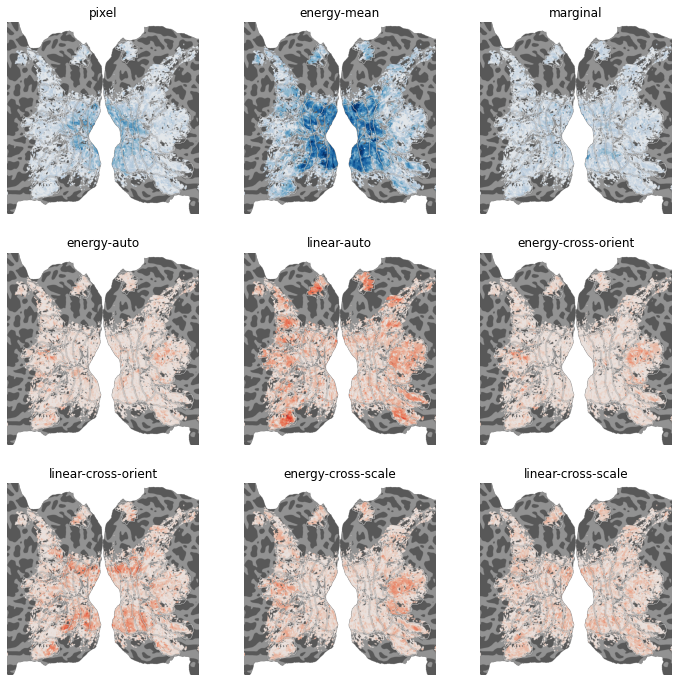

In [55]:
import PIL
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 12)

plt.figure(figsize=(12,12))

feat_types_plot = [0,1,3,4,5,6,7,8,9]
for fi, ff in enumerate(feat_types_plot):
    
    fn2save_cropped = os.path.join(default_paths.fig_path, \
                                   'S%02d_texture_unique_%s_%s_cropped.png'%(ss, feature_types_simple[ff], viewname))
    im = PIL.Image.open(fn2save_cropped)

    plt.subplot(3,3,fi+1);
    plt.imshow(im)
    plt.title(feature_types_simple[ff])
    # plt.axvline(im.size[0]/2,color='k')
    # plt.axhline(im.size[1]/2,color='k')
    plt.axis('off')
    
fn2save = os.path.join(default_paths.fig_path, 'texture_allsubsets_S%d.pdf'%ss)
plt.savefig(fn2save,dpi=1000)